# Problem Overview

The University of Pittsburg manages numerous public events each year.  In an effor to drive engagement, the university would like to target specific departments for each event.  The university has provided a list of 400+ event titles and abstracts, and the course descriptions for 150+ majors/departments within the university.  

The goal is to take the event title and description and provide a list of departments that would most applicable to attend.  

### Imports

In [138]:
import pandas as pd
import numpy as np
from pathlib import Path
import boto3
import pickle
import sagemaker
from sagemaker import get_execution_role
import matplotlib.pyplot as plt
from fastai.text import *
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans

In [88]:
np.set_printoptions(precision=4, suppress=True)

### Data

#### Load

In [89]:
# copy data from s3 bucket
!mkdir /tmp/data/

mkdir: cannot create directory ‘/tmp/data/’: File exists


In [225]:
!aws s3 cp s3://random.datasets.sengstacken/UPittsburg/ /tmp/data/ --recursive

download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotation-tool/data.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotation-tool/data.json
download: s3://random.datasets.sengstacken/UPittsburg/events.csv to ../../../../../tmp/data/events.csv
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotation-tool/template.liquid to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotation-tool/template.liquid
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/consolidated-annotation/consolidation-request/iteration-1/2020-01-07_22:43:49.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/consolidated-annotation/consolidation-request/iteration-1/2020-01-07_22:43:49.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/consolidated-ann

download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/consolidated-annotation/consolidation-response/iteration-1/2020-01-07_22:50:17.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/consolidated-annotation/consolidation-response/iteration-1/2020-01-07_22:50:17.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/0/2020-01-07_22:29:40.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/0/2020-01-07_22:29:40.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/100/2020-01-07_22:41:53.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/100/2020-01-07_22:41:53.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth

download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/109/2020-01-07_22:41:57.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/109/2020-01-07_22:41:57.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/127/2020-01-07_22:37:06.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/127/2020-01-07_22:37:06.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/12/2020-01-07_22:34:51.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/12/2020-01-07_22:34:51.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-respon

download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/153/2020-01-07_22:39:33.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/153/2020-01-07_22:39:33.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/149/2020-01-07_22:37:27.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/149/2020-01-07_22:37:27.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/142/2020-01-07_22:41:57.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/142/2020-01-07_22:41:57.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-resp

download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/18/2020-01-07_22:29:39.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/18/2020-01-07_22:29:39.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/180/2020-01-07_22:40:01.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/180/2020-01-07_22:40:01.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/179/2020-01-07_22:39:40.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/179/2020-01-07_22:39:40.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-respon

download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/203/2020-01-07_22:36:57.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/203/2020-01-07_22:36:57.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/209/2020-01-07_22:39:34.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/209/2020-01-07_22:39:34.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/208/2020-01-07_22:37:12.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/208/2020-01-07_22:37:12.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-resp

download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/234/2020-01-07_22:39:30.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/234/2020-01-07_22:39:30.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/236/2020-01-07_22:39:42.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/236/2020-01-07_22:39:42.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/24/2020-01-07_22:39:18.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/24/2020-01-07_22:39:18.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-respon

download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/261/2020-01-07_22:37:40.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/261/2020-01-07_22:37:40.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/262/2020-01-07_22:42:02.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/262/2020-01-07_22:42:02.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/266/2020-01-07_22:39:34.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/266/2020-01-07_22:39:34.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-resp

download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/297/2020-01-07_22:42:00.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/297/2020-01-07_22:42:00.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/288/2020-01-07_22:37:21.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/288/2020-01-07_22:37:21.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/293/2020-01-07_22:39:17.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/293/2020-01-07_22:39:17.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-resp

download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/321/2020-01-07_22:43:39.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/321/2020-01-07_22:43:39.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/320/2020-01-07_22:40:02.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/320/2020-01-07_22:40:02.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/318/2020-01-07_22:37:41.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/318/2020-01-07_22:37:41.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-resp

download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/35/2020-01-07_22:34:59.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/35/2020-01-07_22:34:59.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/348/2020-01-07_22:41:51.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/348/2020-01-07_22:41:51.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/350/2020-01-07_22:41:47.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/350/2020-01-07_22:41:47.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-respon

download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/374/2020-01-07_22:34:45.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/374/2020-01-07_22:34:45.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/364/2020-01-07_22:41:51.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/364/2020-01-07_22:41:51.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/377/2020-01-07_22:39:15.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/377/2020-01-07_22:39:15.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-resp

download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/402/2020-01-07_22:37:19.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/402/2020-01-07_22:37:19.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/401/2020-01-07_22:34:41.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/401/2020-01-07_22:34:41.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/41/2020-01-07_22:37:11.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/41/2020-01-07_22:37:11.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-respon

download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/67/2020-01-07_22:36:50.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/67/2020-01-07_22:36:50.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/69/2020-01-07_22:39:35.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/69/2020-01-07_22:39:35.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/7/2020-01-07_22:37:08.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/7/2020-01-07_22:37:08.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/ite

download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/98/2020-01-07_22:37:09.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/98/2020-01-07_22:37:09.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/96/2020-01-07_22:39:46.json to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/96/2020-01-07_22:39:46.json
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/manifests/output/output.manifest to ../../../../../tmp/data/groundtruth/upittsburg-event-labeling/manifests/output/output.manifest
download: s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/annotations/worker-response/iteration-1/95/2020-01-07_22:39:54.json to ../../../../../tmp/data/grou

In [226]:
!ls -lrt /tmp/data 

total 22076
-rw-rw-r-- 1 ec2-user ec2-user     6704 Jan  5 02:56 majors.csv
-rw-rw-r-- 1 ec2-user ec2-user 10171500 Jan  5 03:01 major_to_course_description.csv
-rw-rw-r-- 1 ec2-user ec2-user   176641 Jan  5 03:15 localist_events.json
-rw-rw-r-- 1 ec2-user ec2-user   119476 Jan  6 02:42 events.csv
-rw-rw-r-- 1 ec2-user ec2-user 10830716 Jan  7 15:43 dataset-20200107T094287.manifest
-rw-rw-r-- 1 ec2-user ec2-user  1281617 Jan 14 23:26 event_attendance_with_major.csv
drwxrwxr-x 3 ec2-user ec2-user     4096 Jan 14 23:27 groundtruth


In [228]:
attendance = pd.read_csv('/tmp/data/event_attendance_with_major.csv')

In [231]:
attendance['event_id'].unique

<bound method Series.unique of 0              1533773
1       30280084873495
2       30326540300595
3       30326861983653
4       31201039233884
5       31220115834550
6       31449177279583
7       31291465940967
8       31333563911012
9       31900717808126
10      30457649710459
11      31212061261310
12             1615785
13      30831732184443
14             1532066
15      31035306309918
16      31061666518811
17      31777805049175
18             1588196
19             1632519
20      30475393548025
21             1489429
22             1640012
23      30326861983653
24      30565641679647
25      31147790507457
26             1536179
27      31254119128086
28      31123806256881
29      31059086954968
             ...      
1889    31194380571026
1890    31220138853923
1891    31333563911012
1892    30565641679647
1893    31263800838272
1894    31267474057144
1895    31386997659879
1896           1492876
1897           1564151
1898           1651606
1899    31059086954968
190

,event_id,event_title,event_description,attendee_major


In [175]:
# convert .json file to csv.  Note that the .json file does not adhear to the .json standard formatting and cannot be read in using the json library
list_temp = []
temp = []

with open('/tmp/data/localist_events.json') as json_file:
    
    for line in json_file.readlines():
        
        line = line.strip('\n')
        t = line.split(sep='": ')
        
        if "EVENT_ID" in line:
            temp.append(t[1].strip(','))
        if  "TITLE" in line:
            temp.append(t[1].strip(',').strip('"'))
        if "DESCRIPTION_TEXT" in line:
            t = line.split(sep=': ')
            temp.append(t[1].strip('"'))
            list_temp.append(temp)
            temp = []
            
events_df = pd.DataFrame(list_temp,columns=['event','title','description'])

In [102]:
events_df

,event,title,description
0,31201141834958,Market-Proof Your Retirement: TIAA Live Webinar,In retirement-and the years leading up to it-p...
1,31201151588073,Paying Yourself: Income Options in Retirement:...,You can learn the rules that govern retirement...
2,31201165952813,Demystifying Life Insurance: TIAA Live Webinar,Life insurance can play a critical role in you...
3,31201173825427,Halfway There: A Retirement Checkpoint: TIAA L...,Give yourself a mid-career financial checkup t...
4,31201252089868,Planning for Diminished Capacity and Illness: ...,Aging can change many things in a person's lif...
5,31201261206354,Postcards from the Future: A Woman's Guide to ...,Fewer years in the workforce. Longer life span...
6,31201271336489,Responsible Investing - Portfolios with Purpos...,Did you know that responsible investing (RI) e...
7,31201296188040,Inside Money: Managing Income and Debt: TIAA L...,Discover how to help make your money work hard...
8,31201305042157,"Planning for Retirement - The Why, What, and H...",This webinar will discuss the challenges and r...
9,31201312133156,All About IRAs: TIAA Live Webinar,"You can learn the facts on IRAs, how an IRA ma..."


In [103]:
#look for duplicate event names and descriptions
events_df = events_df.drop_duplicates(['title','description'])

In [104]:
events_df

,event,title,description
0,31201141834958,Market-Proof Your Retirement: TIAA Live Webinar,In retirement-and the years leading up to it-p...
1,31201151588073,Paying Yourself: Income Options in Retirement:...,You can learn the rules that govern retirement...
2,31201165952813,Demystifying Life Insurance: TIAA Live Webinar,Life insurance can play a critical role in you...
3,31201173825427,Halfway There: A Retirement Checkpoint: TIAA L...,Give yourself a mid-career financial checkup t...
4,31201252089868,Planning for Diminished Capacity and Illness: ...,Aging can change many things in a person's lif...
5,31201261206354,Postcards from the Future: A Woman's Guide to ...,Fewer years in the workforce. Longer life span...
6,31201271336489,Responsible Investing - Portfolios with Purpos...,Did you know that responsible investing (RI) e...
7,31201296188040,Inside Money: Managing Income and Debt: TIAA L...,Discover how to help make your money work hard...
8,31201305042157,"Planning for Retirement - The Why, What, and H...",This webinar will discuss the challenges and r...
9,31201312133156,All About IRAs: TIAA Live Webinar,"You can learn the facts on IRAs, how an IRA ma..."


In [233]:
events_df['event'].unique

<bound method Series.unique of 0      31201141834958
1      31201151588073
2      31201165952813
3      31201173825427
4      31201252089868
5      31201261206354
6      31201271336489
7      31201296188040
8      31201305042157
9      31201312133156
10     31201755130796
11     31202554016854
12     31202556326225
13     31203003589203
14     31203051136138
15     31210174407120
16     31210280645010
17     31210283401350
18     31210324505834
19     31210345809642
20     31218643448333
21     31220194391552
22     31220282504006
23     31220355398268
24     31220492882026
25     31220731672285
26     31220791250979
27     31220881257238
28     31220909282472
29     31254994523714
            ...      
415    31149927206010
416    31158430700946
417    31183933110851
418    31183940015159
419    31184468823976
420    31194267125279
421    31194380571026
422    31194942097516
423    31195992867456
424    31201112882774
425    31201129191096
426    31812666526044
427    31812671451629
4

In [108]:
# save the cleaned csv
events_df.to_csv('/tmp/data/events.csv')

In [109]:
# push back to S3 bucket
!aws s3 cp '/tmp/data/events.csv' s3://random.datasets.sengstacken/UPittsburg/

upload: ../../../../../tmp/data/events.csv to s3://random.datasets.sengstacken/UPittsburg/events.csv


In [34]:
course_df = pd.read_csv('/tmp/data/major_to_course_description.csv',encoding='iso-8859-1')

In [110]:
course_df

,label,text
0,Accounting,The purpose of cross-registration through the ...
1,Accounting,The purpose of cross-registration through the ...
2,Accounting,An introduction to the accounting functions us...
3,Accounting,Deals with the significance and use of basic a...
4,Accounting,Independent study in a topic in accounting. Pe...
5,Accounting,This course provides the fundamentals of accou...
6,Accounting,Study focuses on the role of accounting princi...
7,Accounting,Blends the theory and current practice of fina...
8,Accounting,Continuation of ACCT 0221 which covers such to...
9,Accounting,AN INTENSIVE ANALYSIS OF THE EVALUATION MEASU...


In [14]:
majors_df

,MAJOR
0,A&S/Business Dual Major
1,Accounting
2,Actuarial Mathematics
3,Admin and Policy Studies
4,Administration of Justice
5,Africana Studies
6,American Sign Language
7,Anthropology
8,Applied Behavior Analysis
9,Applied Developmental Psychology


In [182]:
# join all of the courses together by each major
courses_major_df = course_df.groupby('label').agg({'text': lambda x: ' '.join(x)})
courses_major_df.reset_index(inplace=True)
courses_major_df['test'] = courses_major_df['text'].str.lower()

In [ ]:
# Explore Dataset
id = 31203051136138
attendance[attendance['event_id'] == id]

In [242]:
# how many events are in the attendance records?
a = events_df['event'].unique()
b = attendance['event_id'].unique()
print(len(a))
print(len(b))
print('Events in both:  ',set(a) & set(b)) # intersection

445
762
Events in both:   set()


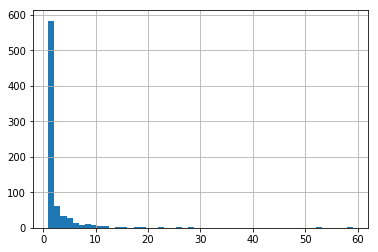

In [269]:
total_attendance = attendance.groupby('event_id').count()
total_attendance['event_title'].hist(bins=50)

In [270]:
total_attendance.sort_values(by='event_title',ascending=False)

,event_title,event_description,attendee_major
event_id,,,
31086506741111,59,59,59
30228895576113,53,53,53
31635861533467,28,28,28
31059086954968,28,28,28
30972358213474,26,26,26
30955117537238,26,26,26
31184468823976,22,22,22
31583099319199,19,19,19
30663283586699,18,18,18


EVENT TITLE:   Volunteer Fair
EVENT DESCRIPTION:   Interested in volunteering? Connect with Community Agencies and learn more about their volunteer opportunities.
Attendees
['Media & Prof Communications' 'Mechanical Engineering' 'Administration of Justice' 'Accounting' 'Undeclared'
 'Instruction and Learning' 'Communication: Rhet & Comm' 'Business Administration' 'Psychology' 'Neuroscience'
 'Admin and Policy Studies' 'Mathematics-Economics' 'Social Work' 'Mkting Sci and Bus Analytics' 'Information Science'
 'Sup Chn Mgmt and Bus Analytics' 'Biomedical Informatics' 'Public Health Genetics' 'Biological Sciences'
 'Accounting and Bus Analytics' 'Computer Science']


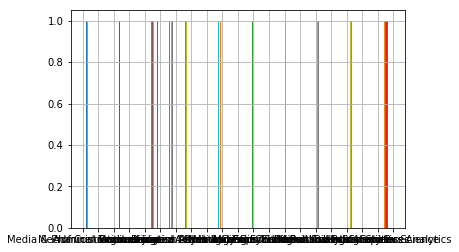

In [288]:
id = 31059086954968
temp = attendance[attendance['event_id']==id]
print('EVENT TITLE:  ', temp['event_title'].iloc[0])
print('EVENT DESCRIPTION:  ', temp['event_description'].iloc[0])
print('Attendees')
print(temp['attendee_major'].unique())
temp['attendee_major'].hist()


### Prep Data - Stop Words, Stemming, Lemmatization

This data is text and we need to clean it up and convert it to numbers to start analysis.

#### Stop Words 
Stop words are extremely common words which appear to be little value - examples of such stop words are:  a, all, the, of, on, am, etc.   It should be noted that there is not single list that defines all stop words.  Addtionally, recent research has shown that for deep learning language models, stop word should not be removed


In [184]:
from sklearn.feature_extraction import stop_words
sorted(list(stop_words.ENGLISH_STOP_WORDS))[100:120]

['formerly',
 'forty',
 'found',
 'four',
 'from',
 'front',
 'full',
 'further',
 'get',
 'give',
 'go',
 'had',
 'has',
 'hasnt',
 'have',
 'he',
 'hence',
 'her',
 'here',
 'hereafter']

#### Stemming and Lemmatization

Both Lemmatization and Stemming generate the root form of words.  Examples
* Studies -> Study
* Studying -> Study
* Studious -> Study

Note that stemming is a poor mans version of lemmatization and simply chops off the suffix.  Lemmatization converts the words to real words

In [197]:
import spacy

In [198]:
from spacy.lemmatizer import Lemmatizer
lemmatizer = Lemmatizer()

In [188]:
word_list = ['feet', 'foot', 'foots', 'footing']

In [189]:
[lemmatizer.lookup(word) for word in word_list]

['feet', 'foot', 'foots', 'footing']

In [194]:
!spacy download en_core_web_sm  # download the English Model

    100% |████████████████████████████████| 11.1MB 79.2MB/s ta 0:00:01
  Running setup.py install for en-core-web-sm ... done
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [201]:
nlp = spacy.load('en_core_web_sm')

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [221]:
num_top_words=10

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

def get_all_topic_words(H):
    top_indices = lambda t: {i for i in np.argsort(t)[:-num_top_words-1:-1]}
    topic_indices = [top_indices(t) for t in H]
    return sorted(set.union(*topic_indices))

In [203]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(courses_major_df['text'].values)

In [204]:
X.shape

(155, 22406)

In [205]:
vocab = np.array(vectorizer.get_feature_names())

In [206]:
vocab.shape

(22406,)

In [207]:
vocab[5000:5010]

array(['cope', 'coped', 'copernicans', 'copernicus', 'copies', 'coping', 'copolymer', 'copolymerization', 'copper',
       'coptic'], dtype='<U23')

#### Non-Negative Matrix Factorization (NMF)
note:  you could also use SVD

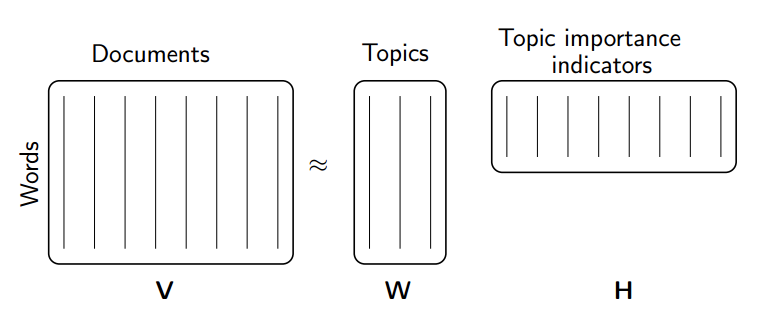

(source: fastai / NMF Tutorial)

In [212]:
from sklearn import decomposition
m,n=X.shape
d=20  # num topics

In [213]:
clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(X)
H1 = clf.components_

In [214]:
show_topics(H1)

['students course writing music work class art study learn performance',
 'health course nursing care students research clinical practice student process',
 'course topics theory include functions math algebra equations calculus linear',
 'course history social world political war historical century american modern',
 'course students student teaching research education instruction learning teacher development',
 'pche provide courses time programs purpose undergraduate permitting educational enriched',
 'course systems data computer students programming topics design information techniques',
 'course political politics students policy international issues states social economic',
 'course biology students laboratory biological human cell research lecture function',
 'language course student writing students second term patterns able vocabulary',
 'economic course theory econ economics topics students intro analysis models',
 'course philosophy phil advanced seminar philosophical stude

### TF-IDF

TF-IDF is a bag of words approach used in natural langauge processing.  The approach produces a sparce matrix that is number of documents by the number of terms.  The values are proportional to the number of occurances of the terms in the document and inversly proportional to the number of occurances in the corpus.

TF = (# occurrences of term t in document) / (# of words in documents)

IDF = log(# of documents / # documents with term t in it)


In [181]:
courses_major_df

,label,text,test
0,Accounting,The purpose of cross-registration through the ...,the purpose of cross-registration through the ...
1,Actuarial Mathematics,class description This is a beginning algebra ...,class description this is a beginning algebra ...
2,Administration of Justice,class description ACQUAINTS STUDENTS WITH NATU...,class description acquaints students with natu...
3,Africana Studies,class description class description Course wil...,class description class description course wil...
4,Anthropology,The purpose of cross-registration through the ...,the purpose of cross-registration through the ...
5,Applied Developmental Psych,PERS & ADJ INTR PSYCH INTRO PSYCH INTRO PSYCHO...,pers & adj intr psych intro psych intro psycho...
6,Applied Mathematics,class description This is a beginning algebra ...,class description this is a beginning algebra ...
7,Architectural Studies,The development of architecture in Europe and ...,the development of architecture in europe and ...
8,Architecture,The purpose of cross-registration through the ...,the purpose of cross-registration through the ...
9,Astronomy,This is an observation-oriented course that wi...,this is an observation-oriented course that wi...


In [149]:
majors = courses_major_df['label'].values

In [215]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(courses_major_df['text'].values)

In [216]:
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(X)
tfidf = tfidf.toarray()

In [217]:
tfidf.shape

(155, 22406)

In [218]:
#### NMF

In [219]:
W1 = clf.fit_transform(tfidf)
H1 = clf.components_



In [220]:
show_topics(H1)

['course literary film german literature cultural century texts culture historical',
 'pche permitting registration enriched council universities colleges educational cross participating',
 'management business accounting course financial mgmt marketing acct organizational cost',
 'biology biol course cell genetics anatomy physiology molecular ecology animal',
 'care health nursing course clinical management restricted healthcare patient students',
 'course calc math calculus algebra equations topics alg linear theory',
 'political course economic social politics policy history world war international',
 'teaching childhood teacher course classroom students candidates school early instructional',
 'course media communication television broadcast mass production radio students comm',
 'course digital students texts public research creating data sciences extraction',
 'design engineering systems course analysis control computer applications methods topics',
 'physics phys bas phy sc intr

In [222]:
ind = get_all_topic_words(H1)
vocab[ind]

array(['accounting', 'acct', 'alg', 'algebra', ..., 'world', 'write', 'writing', 'written'], dtype='<U23')

In [223]:
W1.shape, H1[:, ind].shape

((155, 20), (20, 161))

In [224]:
ind

[908,
 913,
 1322,
 1327,
 1501,
 1527,
 1577,
 1764,
 1980,
 2132,
 2464,
 2757,
 2764,
 3113,
 3244,
 3300,
 3314,
 3362,
 3436,
 3590,
 3621,
 3789,
 3992,
 4034,
 4207,
 4280,
 4348,
 4512,
 4918,
 5081,
 5090,
 5125,
 5188,
 5222,
 5226,
 5270,
 5347,
 5349,
 5482,
 5701,
 5857,
 6095,
 6652,
 6660,
 6699,
 6710,
 6753,
 7051,
 7084,
 7117,
 7120,
 7139,
 7184,
 7254,
 7320,
 7536,
 7641,
 7824,
 8105,
 8140,
 8164,
 8210,
 8821,
 8876,
 8880,
 8928,
 9118,
 9132,
 9472,
 9473,
 9668,
 9681,
 10496,
 10655,
 10676,
 10692,
 10772,
 10819,
 10957,
 11155,
 11290,
 11358,
 11367,
 11647,
 11687,
 11718,
 11800,
 11983,
 12050,
 12053,
 12320,
 12404,
 12527,
 12576,
 12613,
 12733,
 12751,
 12953,
 12971,
 13223,
 13297,
 14214,
 14221,
 14529,
 14893,
 14973,
 15012,
 15161,
 15318,
 15398,
 15407,
 15413,
 15421,
 15433,
 15645,
 15665,
 15688,
 15699,
 15704,
 16252,
 16289,
 16620,
 16767,
 16859,
 16985,
 17260,
 17546,
 17645,
 18003,
 18044,
 18048,
 18178,
 18247,
 18264,
 1

In [154]:
n_clusters = 30

In [155]:
km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=10,
                verbose=True)
y_kmeans = km.fit_predict(tfidf)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 27.284423924515405
start iteration
done sorting
end inner loop
Iteration 1, inertia 27.22067087930469
start iteration
done sorting
end inner loop
Iteration 2, inertia 27.22067087930469
center shift 0.000000e+00 within tolerance 1.692536e-09
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 27.187165934799722
start iteration
done sorting
end inner loop
Iteration 1, inertia 26.948382682017836
start iteration
done sorting
end inner loop
Iteration 2, inertia 26.948382682017836
center shift 0.000000e+00 within tolerance 1.692536e-09
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 28.054860982476644
start iteration
done sorting
end inner loop
Iteration 1, inertia 27.739812423521936
start iteration
done sorting
end inner loop
Iteration 2, inertia 27.65596657867864
start iteration
done sorting
end inner loop
Iteration 3, inerti

In [158]:
for class_ in range(n_clusters):
    print('Cluster #'+str(class_))
    temp_count = 0
    
    for i,cluster in enumerate(y_kmeans):
        
        if cluster == class_:
            print(majors[i],end=', ')
            temp_count+=1
    print()
    print('Total Number: '+str(temp_count))
    print()

Cluster #0
Biology Education 7-12, Ecology and Evolution, Microbiology, Molecular Biology, 
Total Number: 4

Cluster #1
Accounting, Bus Computer & Inform Tech, Business Information Systems, Business Management, Finance, Global Management, Human Resources Management, Management, Management-Accounting, Marketing, Supply Chain Management, 
Total Number: 11

Cluster #2
Anthropology, History, History and Phil of Science, History-Political Science, Political Science, Public Policy, Religious Studies, Sociology, 
Total Number: 8

Cluster #3
Africana Studies, Architectural Studies, Classics, English Education 7-12, English Literature, French, German Lang and Cultural St, History of Art & Architecture, Interdis German Studies, Visual and Performing Arts, 
Total Number: 10

Cluster #4
Biology, Chemical Engineering, Chemistry, Computational Biology, Computer Science, Environmental Studies, Materials Science and Engr, Mechanical Engineering, Mechanical Engineering Tech, Music, Philosophy, Psycholo

### Word Embeddings

The GloVE (Global Vectors) pretrained model is one example of pretrained word vectors.  This pretrained model was developed as an open source project at Stanford.  The models was trained on 6B tokens from Wikipedia and Gigaword datasets.

Glove is available at http://nlp.stanford.edu/data/glove.6B.zip  To download and unzip the files from the command line, you can run:

In [161]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-01-06 16:12:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-06 16:12:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-06 16:12:11--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [165]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [166]:
!ls

events.csv	   glove.6B.300d.txt  UPittsburg.NLP.Event2Department.ipynb
glove.6B.100d.txt  glove.6B.50d.txt
glove.6B.200d.txt  glove.6B.zip


In [168]:
!head glove.6B.100d.txt

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062
, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.52158 

In [169]:
embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [170]:
embedding_dict

{'the': array([-0.0382, -0.2449,  0.7281, -0.3996, ..., -0.5203, -0.1459,  0.8278,  0.2706], dtype=float32),
 ',': array([-0.1077,  0.1105,  0.5981, -0.5436, ..., -0.3511, -0.8316,  0.4529,  0.0826], dtype=float32),
 '.': array([-0.3398,  0.2094,  0.4635, -0.6479, ..., -0.3924, -0.2339,  0.473 , -0.0288], dtype=float32),
 'of': array([-0.1529, -0.2428,  0.8984,  0.17  , ..., -0.5609, -0.591 ,  1.0039,  0.2066], dtype=float32),
 'to': array([-0.1897,  0.05  ,  0.1908, -0.0492, ..., -0.0382, -0.398 ,  0.4765, -0.1598], dtype=float32),
 'and': array([-0.072 ,  0.2313,  0.0237, -0.5064, ..., -0.4993, -0.7189,  0.8689,  0.1954], dtype=float32),
 'in': array([ 0.0857, -0.222 ,  0.1657,  0.1337, ..., -0.2069, -0.0743,  0.7581, -0.3424], dtype=float32),
 'a': array([-0.2709,  0.044 , -0.0203, -0.174 , ..., -0.0109, -0.4923,  0.6369,  0.2364], dtype=float32),
 '"': array([-0.3046, -0.2365,  0.1758, -0.7285, ..., -0.3908, -0.8456, -0.0354,  0.1704], dtype=float32),
 "'s": array([ 0.5885, -0.2025

In [ ]:
### Word2Vec

In [172]:
!pip install gensim

    100% |████████████████████████████████| 24.2MB 1.9MB/s eta 0:00:01
    100% |████████████████████████████████| 71kB 32.9MB/s ta 0:00:01
  Running setup.py bdist_wheel for smart-open ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/ab/10/93/5cff86f5b721d77edaecc29959b1c60d894be1f66d91407d28
Successfully built smart-open
fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [173]:
import gensim

In [ ]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [ ]:
# Load Google's pre-trained Word2Vec model.
model = gensim.models.Word2Vec.load_word2vec_format('./model/GoogleNews-vectors-negative300.bin', binary=True)  

### Links:

* https://github.com/fastai/word-embeddings-workshop/blob/master/Word%20Embeddings.ipynb
* https://nlp.town/blog/sentence-similarity/
